[Word embeddings Tutorial in TensorFlow 2.0](https://www.tensorflow.org/tutorials/text/word_embeddings)

In [0]:
import tensorflow as tf

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [0]:
import matplotlib.pyplot as plt

# Embedding Layer

Create and Embedding layer to map integer encoded tokens to dense vectors

In [0]:
embedding_layer = tf.keras.layers.Embedding(input_dim=1000, output_dim=5)

Let's test the embedding layer by passing a vector with random integer values

In [5]:
embedding_layer(tf.constant([1, 2, 3, 999]))

<tf.Tensor: shape=(4, 5), dtype=float32, numpy=
array([[ 0.04648489, -0.04847095, -0.04736141, -0.00178094,  0.04458966],
       [-0.01664212, -0.00362859, -0.04557537,  0.02738701,  0.00064861],
       [-0.00542611,  0.0007062 ,  0.03764484, -0.00022081,  0.0304679 ],
       [ 0.02659723,  0.00344061, -0.01342522,  0.03061112,  0.01194257]],
      dtype=float32)>

What are the limits in terms of allowed integer values? Let's try with a negative value (-1) and then a positive value above the maximum number of input dimensions (1001)

In [8]:
try:
  embedding_layer(tf.constant(-1))
except Exception:
  print("We expected an error to happen")

We expected an error to happen


In [9]:
try:
  embedding_layer(tf.constant(1001))
except Exception:
  print("We expected an error to happen")

We expected an error to happen


Ok, we expected that! Let's move forward...

We can pass 2D inputs, as we would if working in a sequence or text problem. That is, (batch_size, sequence_length). The Embedding layer returns then a 3D floating point tensor of shape (batch_size, sequence_length, embedding_dimensionality).

In this case, if we pass a set of 3 sequences of length 4, we will get a tensor with dimensions (3, 4, 5)

In [10]:
real_sequence = tf.constant(
    [
     [4, 10, 3, 2],
     [2, 4, 1, 5],
     [102, 40, 81, 22],
     ]
)
real_embeddings = embedding_layer(real_sequence)
real_embeddings_np = real_embeddings.numpy()
print(real_embeddings_np.shape)
print(real_embeddings_np)

(3, 4, 5)
[[[ 0.00235314 -0.01403177  0.0443331  -0.00093251 -0.00634632]
  [-0.0445886   0.04017819  0.0263827   0.01134465  0.01420883]
  [-0.00542611  0.0007062   0.03764484 -0.00022081  0.0304679 ]
  [-0.01664212 -0.00362859 -0.04557537  0.02738701  0.00064861]]

 [[-0.01664212 -0.00362859 -0.04557537  0.02738701  0.00064861]
  [ 0.00235314 -0.01403177  0.0443331  -0.00093251 -0.00634632]
  [ 0.04648489 -0.04847095 -0.04736141 -0.00178094  0.04458966]
  [-0.0080845   0.0005384  -0.01357831 -0.00474878 -0.00982768]]

 [[ 0.03299589 -0.01934789 -0.02338247  0.01046027  0.00089132]
  [ 0.02787478 -0.02197886  0.00073989  0.02610666 -0.0003572 ]
  [ 0.01049454 -0.00107913 -0.01240262 -0.02326345  0.01700437]
  [ 0.03585149 -0.02232385 -0.01286187  0.0085189   0.03787551]]]


# Learning embeddings from scratch

We will train a sentiment classifier on IMDB movie reviews

In [0]:
(train_data, test_data), info = tfds.load(
    "imdb_reviews/subwords8k", 
    split=(tfds.Split.TRAIN, tfds.Split.TEST), 
    with_info=True, 
    as_supervised=True
)

Let's inspect the words encoder, that can be found in `info.features["text"].encoder`

In [12]:
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [0]:
encoder = info.features["text"].encoder

In [14]:
encoder.subwords[:30]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_',
 't_',
 'with_',
 'for_',
 '.<',
 'on_',
 'but_',
 'movie_',
 ' (',
 'are_',
 'his_']

In [15]:
encoder.vocab_size

8185

Let's inspect the training dataset, `train_data`. But first, apply a random shuffling.

In [16]:
train_data = train_data.shuffle(1000)
test_data = test_data.shuffle(1000)
train_data

<DatasetV1Adapter shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [17]:
for encoded_text, label in train_data.take(5):
  print(f"Encoded text tensor shape: {encoded_text.shape}")
  print(f"Label: {label.numpy()}")

Encoded text tensor shape: (161,)
Label: 0
Encoded text tensor shape: (212,)
Label: 1
Encoded text tensor shape: (218,)
Label: 0
Encoded text tensor shape: (320,)
Label: 1
Encoded text tensor shape: (140,)
Label: 1


Let's try to batch the elements in the dataset with padding. Consult the `tf.data.Dataset.padded_batch` docstring [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#padded_batch).

In [0]:
train_batches = train_data.padded_batch(16)
test_batches = test_data.padded_batch(16)

In [19]:
for train_batch, train_label in train_batches.take(4):
  print(train_batch.shape)
  print(train_batch)
  print("-"*80)

(16, 1032)
tf.Tensor(
[[  12 3059 5086 ...  317 8050 7975]
 [5646    2  920 ...    0    0    0]
 [  19 6918 7961 ...    0    0    0]
 ...
 [1698   95    1 ...    0    0    0]
 [  74   65    2 ...    0    0    0]
 [ 173    9    4 ...    0    0    0]], shape=(16, 1032), dtype=int64)
--------------------------------------------------------------------------------
(16, 534)
tf.Tensor(
[[2288 8001   90 ...    0    0    0]
 [7448 7961 7228 ... 3851 5622 7975]
 [  62    9    4 ...    0    0    0]
 ...
 [1184 8002 7968 ...    0    0    0]
 [7989   10   16 ...    0    0    0]
 [  12 1167 7968 ...    0    0    0]], shape=(16, 534), dtype=int64)
--------------------------------------------------------------------------------
(16, 777)
tf.Tensor(
[[  12  641    7 ...    0    0    0]
 [  19  811    9 ...    0    0    0]
 [3187   89 6545 ...    0    0    0]
 ...
 [  12  304 6219 ...    0    0    0]
 [ 768 5236 2127 ...    0    0    0]
 [7963 6389  884 ...    0    0    0]], shape=(16, 777), dtype=int

# Create a simple model

## Model description

* Next the Embedding layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.
* Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
* This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability (or confidence level) that the review is positive.

In [0]:
embedding_layer_dim = 16
embedding_dense_dim = 16

In [23]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=encoder.vocab_size, output_dim=embedding_layer_dim, mask_zero=True),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(embedding_dense_dim, activation='relu'),
  tf.keras.layers.Dense(1),
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [24]:
simplified_model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=encoder.vocab_size, output_dim=embedding_layer_dim, mask_zero=True),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(1),
])
simplified_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_________________________________________________________________


**NOTE**: This model uses masking thanks to the `mask_zero=True` argument passed to the `Embedding` layer. If it was not set, the zero-padding would used as part of the input, so the padding length would affect the output. See the [masking and padding guide](https://www.tensorflow.org/guide/keras/masking_and_padding) for more detailed information.

In [0]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [0]:
simplified_model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [27]:
# history = model.fit(train_batches, epochs=10, validation_data=test_batches, validation_steps=20)
history = simplified_model.fit(train_batches, epochs=10, validation_data=test_batches, validation_steps=20)

Epoch 1/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.5736 - accuracy: 0.6302 - val_loss: 0.4584 - val_accuracy: 0.8062
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.3629 - accuracy: 0.8459 - val_loss: 0.3484 - val_accuracy: 0.8750
Epoch 3/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.2809 - accuracy: 0.8851 - val_loss: 0.3214 - val_accuracy: 0.8562
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 0.2377 - accuracy: 0.9053 - val_loss: 0.3195 - val_accuracy: 0.8562
Epoch 5/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.2092 - accuracy: 0.9170 - val_loss: 0.2836 - val_accuracy: 0.8656
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1879 - accuracy: 0.9259 - val_loss: 0.3035 - val_accuracy: 0.8750
Epoch 7/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.1710 - accuracy: 0.9339 - val_loss: 0.2456 - val_ac

Let's plot the training and validation curves

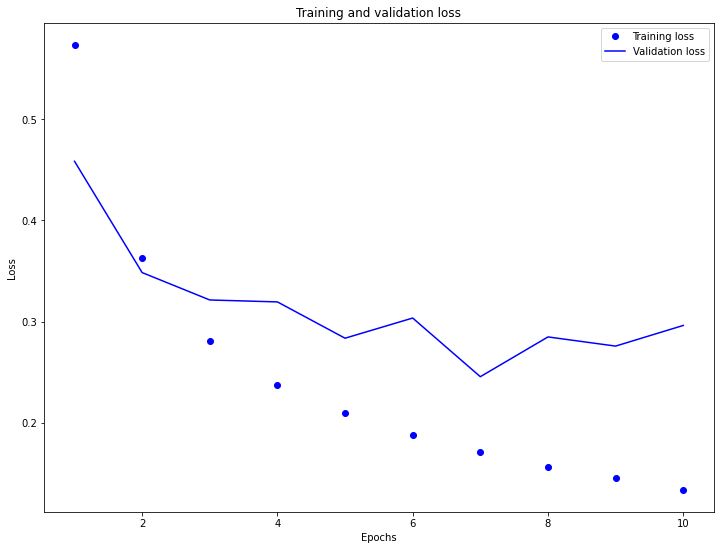

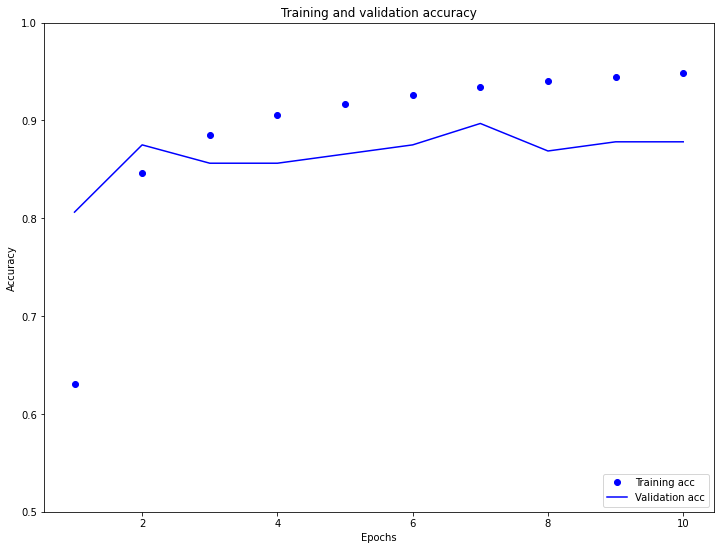

In [28]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))
plt.show()

# Inspect the learnt embeddings

In [29]:
print(model.layers)

[<tensorflow.python.keras.layers.embeddings.Embedding object at 0x7f1519e215f8>, <tensorflow.python.keras.layers.pooling.GlobalAveragePooling1D object at 0x7f1519e217f0>, <tensorflow.python.keras.layers.core.Dense object at 0x7f1519e21908>, <tensorflow.python.keras.layers.core.Dense object at 0x7f1519e21b70>]


In [0]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

In [31]:
print(weights.shape)

(8185, 16)


Let's write the embeddings to disk in TSV (tab-separated values) so that we can visualize them with the [Embedding Projector](http://projector.tensorflow.org/).

In [0]:
import io

encoder = info.features["text"].encoder

out_v = io.open("vecs.tsv", "w", encoding="utf-8")
out_m = io.open("meta.tsv", "w", encoding="utf-8")

# Iterate over all words in the vocabulary and fetch their embedding vector
# Skip 0 as it represents padding
for idx in range(1, len(encoder.subwords)):
  word = encoder.subwords[idx]
  vec = weights[idx]
  out_m.write(word + "\n")
  out_v.write("\t".join([str(x) for x in vec]) + "\n")

out_v.close()
out_m.close()